In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # define layers here
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    
    # output of the function
    def forward(self, x):
        # define the composition of the layers here
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
        

In [14]:
input = torch.randn(1, 1, 28, 28).to(device)
model = MyCNN().to(device)
print(model(input))

tensor([[0.0000, 0.0000, 0.0017, 0.0000, 0.1305, 0.0958, 0.0426, 0.0000, 0.1120,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)


In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = '../data',
    train = True,
    transform = ToTensor()
)
test_data = datasets.MNIST(
    root = '../data',
    train = False,
    transform = ToTensor()
)

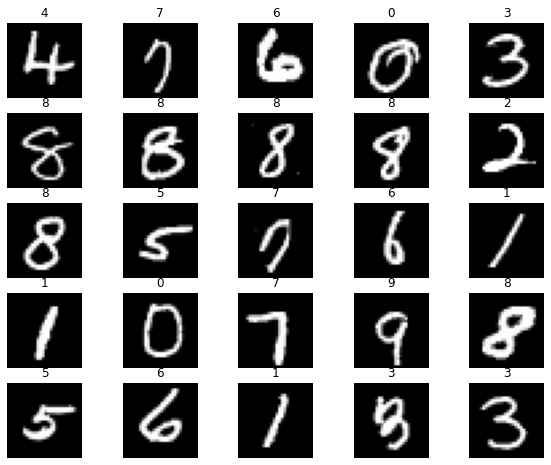

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=200, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=200, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [33]:
l_r = 0.1

model = MyCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=.1)
num_epochs = 25
lmbda = lambda epoch: 0.75
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

for i ,(images,labels) in enumerate(loaders['train']): 

            b_x = images.to(device)
            b_y = labels.to(device)

            output = model(b_x)

            loss = loss_fn(output,b_y)
            print(F.softmax(output[0],dim=0))
            print(b_y[0])
            break

tensor([0.0955, 0.0955, 0.0955, 0.0955, 0.1181, 0.0967, 0.1165, 0.0955, 0.0955,
        0.0955], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(1, device='cuda:0')


Epoch [1/25], Step [100/300], Loss: 2.247
Epoch [1/25], Step [200/300], Loss: 0.774
Epoch [1/25], Step [300/300], Loss: 0.235
Epoch [2/25], Step [100/300], Loss: 0.134
Epoch [2/25], Step [200/300], Loss: 0.075
Epoch [2/25], Step [300/300], Loss: 0.092
Epoch [3/25], Step [100/300], Loss: 0.087
Epoch [3/25], Step [200/300], Loss: 0.164
Epoch [3/25], Step [300/300], Loss: 0.151
Epoch [4/25], Step [100/300], Loss: 0.074
Epoch [4/25], Step [200/300], Loss: 0.070
Epoch [4/25], Step [300/300], Loss: 0.055
Epoch [5/25], Step [100/300], Loss: 0.079
Epoch [5/25], Step [200/300], Loss: 0.036
Epoch [5/25], Step [300/300], Loss: 0.039
Epoch [6/25], Step [100/300], Loss: 0.080
Epoch [6/25], Step [200/300], Loss: 0.124
Epoch [6/25], Step [300/300], Loss: 0.066
Epoch [7/25], Step [100/300], Loss: 0.047
Epoch [7/25], Step [200/300], Loss: 0.108
Epoch [7/25], Step [300/300], Loss: 0.036
Epoch [8/25], Step [100/300], Loss: 0.050
Epoch [8/25], Step [200/300], Loss: 0.043
Epoch [8/25], Step [300/300], Loss

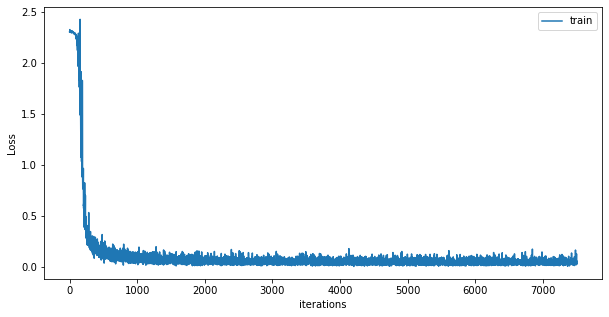

In [34]:
def train(model, loss_fn, train_loader, optimizer, num_epochs, scheduler):
    model.train()
    total_step = len(train_loader)
    train_loss = []
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            train_loss.append(loss)
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}'
                       .format(epoch+1, num_epochs, i+1,
                               total_step, loss.item()))
        scheduler.step()
    plt.figure(figsize=(10,5))
    plt.plot(train_loss,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

train(model, loss_fn, loaders['train'], optimizer, num_epochs, scheduler)

In [9]:
def test(model, test_loader):
    with torch.no_grad():
        model.to('cpu')
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct/ total

print(test(model, loaders['test']))

98.42


In [10]:
print('# of parameters :', sum(p.numel() for p in model.parameters()))

# of parameters : 48490


Epoch [1/25], Step [100/300], Loss: 2.106
Epoch [1/25], Step [200/300], Loss: 0.564
Epoch [1/25], Step [300/300], Loss: 0.243
Epoch [2/25], Step [100/300], Loss: 0.135
Epoch [2/25], Step [200/300], Loss: 0.133
Epoch [2/25], Step [300/300], Loss: 0.069
Epoch [3/25], Step [100/300], Loss: 0.089
Epoch [3/25], Step [200/300], Loss: 0.070
Epoch [3/25], Step [300/300], Loss: 0.102
Epoch [4/25], Step [100/300], Loss: 0.092
Epoch [4/25], Step [200/300], Loss: 0.080
Epoch [4/25], Step [300/300], Loss: 0.118
Epoch [5/25], Step [100/300], Loss: 0.109
Epoch [5/25], Step [200/300], Loss: 0.067
Epoch [5/25], Step [300/300], Loss: 0.078
Epoch [6/25], Step [100/300], Loss: 0.060
Epoch [6/25], Step [200/300], Loss: 0.028
Epoch [6/25], Step [300/300], Loss: 0.024
Epoch [7/25], Step [100/300], Loss: 0.069
Epoch [7/25], Step [200/300], Loss: 0.080
Epoch [7/25], Step [300/300], Loss: 0.062
Epoch [8/25], Step [100/300], Loss: 0.021
Epoch [8/25], Step [200/300], Loss: 0.011
Epoch [8/25], Step [300/300], Loss

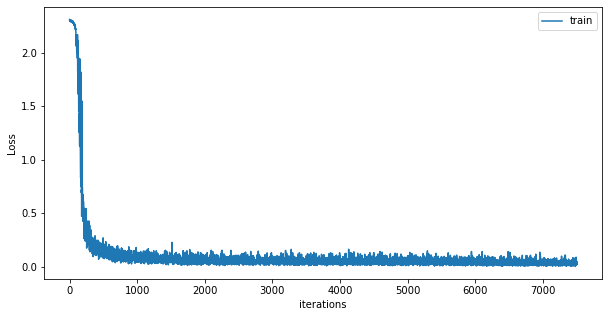

In [35]:
from torch.optim.swa_utils import AveragedModel, SWALR

l_r2=0.1
model2 = MyCNN().to(device)
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=l_r2, momentum=0.1)
num_epochs2 = 25
lmbda2 = lambda epoch: 0.75
scheduler2 = optim.lr_scheduler.MultiplicativeLR(optimizer2, lr_lambda=lmbda2)
swa_model = AveragedModel(model2)
swa_start = 10
swa_scheduler = SWALR(optimizer2, swa_lr=0.05)

def train_swa(model, loss_fn, train_loader, optimizer, num_epochs, scheduler, swa_scheduler, swa_start):
    model.train()
    total_step = len(train_loader)
    train_loss = []
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            train_loss.append(loss)
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}'
                       .format(epoch+1, num_epochs, i+1,
                               total_step, loss.item()))
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
            
    torch.optim.swa_utils.update_bn(train_loader, swa_model)
    plt.figure(figsize=(10,5))
    plt.plot(train_loss,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
train_swa(model2, loss_fn2, loaders['train'], optimizer2, num_epochs2, scheduler2, swa_scheduler, swa_start)

In [36]:
print(test(swa_model, loaders['test']))

98.58


In [9]:
filter = torch.randn(1, 2, 3, 3)
input = torch.randn(1, 2, 5, 5)

print(input)

#print(F.conv2d(input, filter, padding=1))

tensor([[[[-1.3251, -1.9504,  0.4313,  0.9603,  0.0801],
          [ 1.8002,  0.3212, -1.2208,  0.6276, -0.3997],
          [ 0.1670,  0.5004, -0.4083, -1.3497,  0.8355],
          [ 0.3903, -0.2023, -0.5413, -1.1786,  1.1248],
          [-0.0793,  1.1370, -0.0049, -0.2439,  0.8170]],

         [[-0.4658, -2.5436, -0.6179,  0.8665, -1.1403],
          [-0.8997, -0.0218,  0.0457, -2.1495,  0.9442],
          [ 0.1463,  0.7895,  0.2359,  1.8022, -0.8158],
          [ 0.8368,  1.4077, -1.1449, -0.0976,  0.1759],
          [ 1.1171,  1.0225,  1.4030,  0.3892,  0.5431]]]])
